In [1]:
from cirq_sic import *
from cirq.contrib.svg import SVGCircuit

import numpy as np
np.set_printoptions(precision=3, suppress=True)

import matplotlib.pyplot as plt

In [ ]:
processor_id = "willow_pink"
globals().update(get_device_data(processor_id))

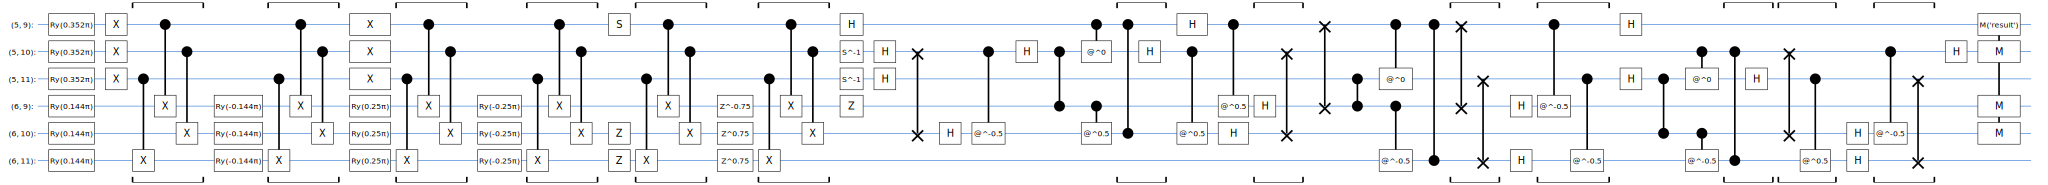

In [6]:
n = 2
ancilla1_qubits = [cirq.GridQubit(5,9), cirq.GridQubit(6,9)]
ancilla2_qubits = [cirq.GridQubit(5,10), cirq.GridQubit(6,10)]  
system_qubits = [cirq.GridQubit(5,11), cirq.GridQubit(6,11)]

circuit = cirq.Circuit((d4_sic_fiducial(system_qubits, conjugate=False),
                        arthurs_kelly(system_qubits, ancilla1_qubits, ancilla2_qubits,\
                                      prepare_fiducial=d4_sic_fiducial, measure=True)))
SVGCircuit(circuit)

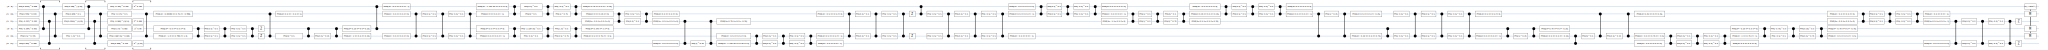

In [7]:
optimized_circuit = process_circuit(circuit, connectivity_graph, gateset, ancilla1_qubits+ancilla2_qubits+system_qubits)
device.validate_circuit(optimized_circuit)
SVGCircuit(optimized_circuit)

In [8]:
# Exact simulation
N = 50000
s = cirq.Simulator()
samples = s.run(optimized_circuit, repetitions=N)
counts = samples.histogram(key="result")
exact_freqs = np.array([v for k, v in sorted(counts.items())])/N
exact_freqs

array([0.248, 0.048, 0.052, 0.048, 0.05 , 0.051, 0.05 , 0.049, 0.051,
       0.05 , 0.051, 0.05 , 0.049, 0.051, 0.052, 0.049])

In [9]:
# Direct calculation
d = 4
phi = d4_sic_fiducial_ket()
E = wh_povm(phi)
p = np.array([phi.conj() @ e @ phi for e in E]).real; p

array([0.25, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05])

In [8]:
# Noisy simulation
N = 50000
samples = sampler.run(optimized_circuit, repetitions=N)
counts = samples.histogram(key="result")
noisy_freqs = np.array([v for k, v in sorted(counts.items())])/N

# Rorder the probabilities
noisy_freqs = change_conjugate_convention(noisy_freqs)
noisy_freqs

array([0.196, 0.071, 0.073, 0.059, 0.041, 0.059, 0.038, 0.053, 0.045,
       0.042, 0.049, 0.053, 0.069, 0.048, 0.051, 0.052])

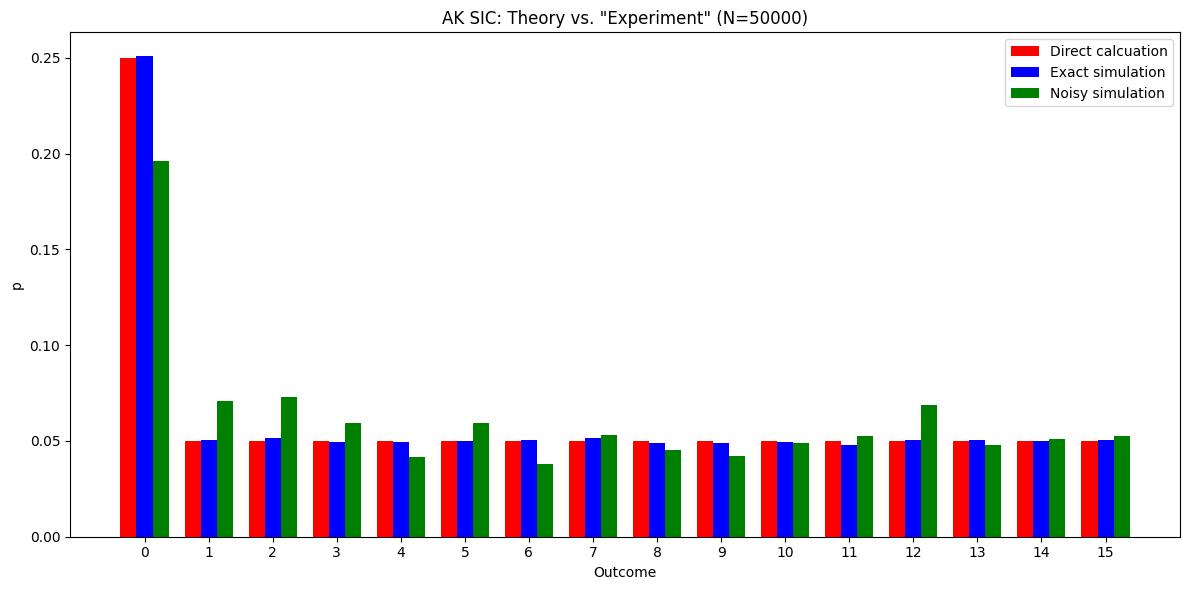

In [26]:
x_pos = np.arange(2**4) 
bar_width = 0.25
plt.figure(figsize=(12, 6))
plt.bar(x_pos - bar_width, p, width=bar_width, label='Direct calcuation', color='red')
plt.bar(x_pos, exact_freqs, width=bar_width, label='Exact simulation', color='blue')
plt.bar(x_pos + bar_width, noisy_freqs, width=bar_width, label='Noisy simulation', color='green')
plt.ylabel('p')
plt.xlabel('Outcome')
plt.title('AK SIC: Theory vs. "Experiment" (N=%d)' % N)
plt.xticks(x_pos)
plt.legend()
plt.tight_layout()
plt.savefig("img/ak_theory_vs_experiment.pdf", bbox_inches='tight')

## Gate counts

### Base circuit

In [10]:
fiducial_circuit = cirq.Circuit((d4_sic_fiducial(ancilla1_qubits)))
get_gate_counts(fiducial_circuit)

--- Gate Counts (by type) ---
Ry: 5
_PauliX: 2
CXPowGate: 6
ZPowGate: 3
HPowGate: 1


In [12]:
ancilla_prep_circuit = cirq.Circuit((ready_arthurs_kelly_ancillas(ancilla1_qubits, ancilla2_qubits)))
get_gate_counts(ancilla_prep_circuit)

--- Gate Counts (by type) ---
SwapPowGate: 1
HPowGate: 2
CZPowGate: 5


In [13]:
ak_circuit = cirq.Circuit((arthurs_kelly_coupling(system_qubits, ancilla1_qubits, ancilla2_qubits)))
get_gate_counts(ak_circuit)

--- Gate Counts (by type) ---
HPowGate: 12
CZPowGate: 14
SwapPowGate: 6


In [14]:
get_gate_counts(circuit)

--- Gate Counts (by type) ---
Ry: 15
_PauliX: 6
CXPowGate: 18
ZPowGate: 9
HPowGate: 17
SwapPowGate: 7
CZPowGate: 19
MeasurementGate: 1


In [15]:
len(circuit.moments)

41

### Optimized circuit

In [16]:
get_gate_counts(optimized_circuit)

--- Gate Counts (by type) ---
PhasedXPowGate: 89
CZPowGate: 69
ZPowGate: 10
PhasedXZGate: 57
MeasurementGate: 1


In [17]:
len(optimized_circuit.moments)

126